# Export Data for Web Application 

In [41]:
from cflp_function import cflp, plot_result, store_data_to_pickle, load_data_from_pickle, find_farm_not_in_solution_plant_in_solution, get_arc
from pulp import *
import pandas as pd
import numpy as np
import pydeck as pdk
import geopandas as gpd
import os
import rasterio
from rasterio.plot import reshape_as_image
from shapely.geometry import mapping

import matplotlib.pyplot as plt

%matplotlib inline

In [40]:
from pyscipopt import Model

ImportError: dlopen(/Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pyscipopt/scip.cpython-311-darwin.so, 0x0002): Library not loaded: @rpath/libscip.8.0.dylib
  Referenced from: <DBC66DFF-2DA1-30DA-99E2-136A45D645BD> /Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pyscipopt/scip.cpython-311-darwin.so
  Reason: tried: '/usr/local/lib/libscip.8.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/lib/libscip.8.0.dylib' (no such file), '/Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pyscipopt/../../../libscip.8.0.dylib' (no such file), '/usr/local/lib/libscip.8.0.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/lib/libscip.8.0.dylib' (no such file), '/Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pyscipopt/../../../libscip.8.0.dylib' (no such file), '/Users/wenyuc/opt/anaconda3/envs/bioze/bin/../lib/libscip.8.0.dylib' (no such file), '/Users/wenyuc/opt/anaconda3/envs/bioze/bin/../lib/libscip.8.0.dylib' (no such file), '/usr/local/lib/libscip.8.0.dylib' (no such file), '/usr/lib/libscip.8.0.dylib' (no such file, not in dyld cache)

In [27]:
# from pyscipopt import Model
from ortools.sat.python import cp_model
from ortools.linear_solver import pywraplp

In [10]:
# version_number = 6

### Load files and create parameters
* q_j max capacity of each j 
* f_j fixed cost of establishing each j
* set F set of farm locations
* set P set of potential digester locations
* C_ij transportation matrix 
* p_i 
* alpha
* mu

In [42]:
# Import farm_cluster_mock_5 dataset - which is the mock data for potential digester locations
potential_digester_location = pd.read_csv(r'./farm_cluster_mock_5.csv')
potential_digester_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [43]:
farm = pd.read_csv(r"./farm_mock.csv")
farm.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,507920,2454,957060.0
1,1,6.837249,52.425084,507950,9827,3832530.0
2,2,6.859361,52.386225,507953,8660,3377400.0
3,3,6.753483,52.434382,507962,2913,1136070.0
4,4,6.484077,52.243620,507964,6488,2530320.0


In [30]:
folder_path = 'app_data'

In [31]:
Farm = load_data_from_pickle(folder_path, 'Farm_test.pickle')
        # set P     set of potential digester locations
    # Dictionary 
        # p_i       manure production of each i
manure_production = load_data_from_pickle(folder_path, 'manure_production_test.pickle')
        # q_j       max capacity of each j 
    # Float
        # alpha     total manure production
total_manure = load_data_from_pickle(folder_path, 'total_manure_test.pickle')
    # Float defined here
        # mu        manure utilization target 

In [48]:
Plant = load_data_from_pickle(folder_path, 'Plant_test.pickle')
max_capacity = load_data_from_pickle(folder_path, 'max_capacity_test.pickle')
fixed_cost = load_data_from_pickle(folder_path, 'fixed_cost_test.pickle')        
transport_cost = load_data_from_pickle(folder_path, 'transportation_cost_test.pickle')

In [32]:

# Plant = load_data_from_pickle(folder_path, 'Plant.pickle')
# max_capacity = load_data_from_pickle(folder_path, 'max_capacity.pickle')
#         # f_j       fixed cost of establishing each j
# fixed_cost = load_data_from_pickle(folder_path, 'fixed_cost.pickle')        
#         # C_ij      transportation matrix 
# transport_cost = load_data_from_pickle(folder_path, 'transportation_cost.pickle')

In [34]:
def filter_Plant(plant_to_keep, original_dict):
    # Extract key-value pairs where the key is not in the list
    filtered_dict = {key: value for key, value in original_dict.items() if key in plant_to_keep}
    return filtered_dict

## CFLP Model
* cflp: the cflp model
* find_farm_not_in_solution_plant_in_solution: disaggregating outputs for result visualization 
* plot_result: plot optimal solution (calls the previous function)

In [44]:
# Define manure use goal (mu)
target = 0.1

In [33]:
# Setting the Problem
prob = LpProblem("Capacitated_Facility_Location_Problem", LpMinimize)

# Defining our Decision Variables
use_plant = LpVariable.dicts("Plant", Plant, 0, 1, LpBinary) 
ser_farm = LpVariable.dicts("Farm_Plant", [(i, j) for i in Farm for j in Plant], 0, 1, LpBinary) 

In [34]:
# Objective Function
prob += lpSum(fixed_cost[j]*use_plant[j] for j in Plant) + lpSum(transport_cost[j][i]*ser_farm[(i,j)] for j in Plant for i in Farm)

# Costraints
for i in Farm:
    prob += lpSum(ser_farm[(i, j)] for j in Plant) <= 1 # Very strange, the model becomes infeasible  if it's == 1, maybe because now the constraint has relaxed and not all farms need to be assigned to facility, which will be the case if ==1

for j in Plant:
    prob += lpSum(manure_production[i] * ser_farm[(i,j)] for i in Farm) <= max_capacity[j]*use_plant[j]

for i in Farm:
    for j in Plant:
        prob += ser_farm[(i,j)] <= use_plant[j]

# Add a constraint to ensure at least x% of total manure production is sent to plants
prob += lpSum(manure_production[i] * ser_farm[(i, j)] for i in Farm for j in Plant) >= target * total_manure

In [35]:
# Solve 
prob.solve(PULP_CBC_CMD(msg=True, warmStart=True))
print("Solution Status = ", LpStatus[prob.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/9d84502eabb845dd823b1f2c35e12753-pulp.mps mips /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/9d84502eabb845dd823b1f2c35e12753-pulp.mst timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/9d84502eabb845dd823b1f2c35e12753-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 3723 COLUMNS
At line 32208 RHS
At line 35927 BOUNDS
At line 39503 ENDATA
Problem MODEL has 3718 rows, 3575 columns and 17775 elements
Coin0008I MODEL read with 0 errors
opening mipstart file /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/9d84502eabb845dd823b1f2c35e12753-pulp.mst.
MIPStart values read for 3575 variables.
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.879

KeyboardInterrupt: 

s, 10429 on tree, 2092533.4 best solution, best possible 1879521.4 (339.62 seconds)
Cbc0010I After 55100 nodes, 10427 on tree, 2092533.4 best solution, best possible 1879521.4 (339.91 seconds)
Cbc0010I After 55200 nodes, 10426 on tree, 2092533.4 best solution, best possible 1879521.4 (340.17 seconds)
Cbc0010I After 55300 nodes, 10422 on tree, 2092533.4 best solution, best possible 1879521.4 (340.43 seconds)
Cbc0010I After 55400 nodes, 10424 on tree, 2092533.4 best solution, best possible 1879521.4 (340.69 seconds)
Cbc0010I After 55500 nodes, 10455 on tree, 2092533.4 best solution, best possible 1879521.4 (340.98 seconds)
Cbc0010I After 55600 nodes, 10449 on tree, 2092533.4 best solution, best possible 1879521.4 (341.20 seconds)
Cbc0010I After 55700 nodes, 10456 on tree, 2092533.4 best solution, best possible 1879521.4 (341.46 seconds)
Cbc0010I After 55800 nodes, 10454 on tree, 2092533.4 best solution, best possible 1879521.4 (341.69 seconds)
Cbc0010I After 55900 nodes, 10446 on tree, 2

In [17]:
# # Print the solution of Binary Decision Variables
# Tolerance = 0.0001
# for i in Plant:
#     if use_plant[i].varValue > Tolerance:
#         print("Estalish Facility at site = ", i)

# # Print the solution of Continuous Decision Variables
# for v in prob.variables():
#     print(v.name, "=", v.varValue)

In [49]:
total_cost, total_fixed_cost, total_transport_cost, assignment_decision, use_plant_index = cflp(Plant, Farm, fixed_cost, transport_cost, manure_production, max_capacity, target, total_manure)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/b82d3efffa0a41fe907e7a566a069d0d-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/b82d3efffa0a41fe907e7a566a069d0d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 863 COLUMNS
At line 6564 RHS
At line 7423 BOUNDS
At line 8139 ENDATA
Problem MODEL has 858 rows, 715 columns and 3555 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 70521.9 - 0.00 seconds
Cgl0008I 142 inequality constraints converted to equality constraints
Cgl0004I processed model has 858 rows, 857 columns (857 integer (857 of which binary)) and 3697 elements
Cbc0038I Initial state - 27 integers unsatisfied sum - 3.45359
Cb

In [18]:
# # Check if the opened plants are under-utilized
# total_sum_list = [sum(farm.loc[i, 'manure_t'] for i in value) for value in assignment_decision.values()]

# potential_digester_location['allocated_manure'] = total_sum_list

# # Find the percentage of plant's capacity that is utilized
# potential_digester_location['underutilized'] = 0
# mask = potential_digester_location['allocated_manure'] > 0
# potential_digester_location.loc[mask, 'underutilized'] = (1 - (potential_digester_location.loc[mask, 'allocated_manure'] / potential_digester_location.loc[mask, 'capacity'])) * 100
# potential_digester_location

In [9]:
filename = f"./outputs/cflp_v{6}_{int(target*100)}%manure.png"  # You can choose the file extension (e.g., .png, .jpg, .pdf)

There are no duplicates in the list.


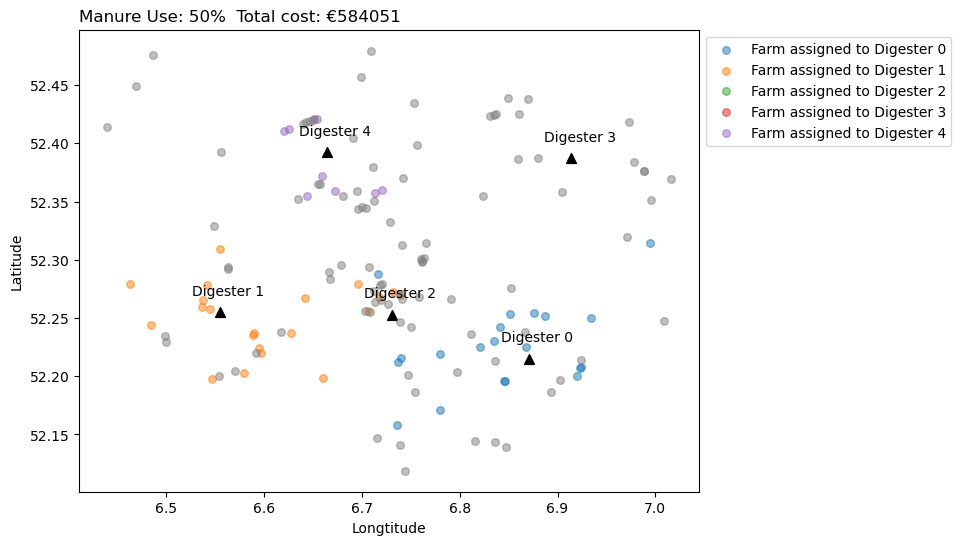

In [10]:
plot_result(Plant, potential_digester_location, assignment_decision, farm, Farm, use_plant_index, target, total_cost, filename, save_fig=False)

In [16]:
for key, value in assignment_decision.items():
    print(f"{key}: {value}")

0: []
1: []
2: [24, 40, 41, 48, 76, 77, 92, 123, 124, 125, 133, 137]
3: []
4: [66, 69, 70, 111, 113, 114, 121, 128]
